<a href="https://colab.research.google.com/github/Cristhian-18/Cristhian-18/blob/main/NLP_CRISTHIAN_CORDOVA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Paso a paso para fine-tuning de BERT

### Paso 1: Instalar dependencias

In [1]:
# Transformers para modelos preentrenados
!pip install -U "transformers>=4.35.0" --quiet

# Datasets y métricas
!pip install -U "datasets>=2.14.0" "evaluate>=0.4.0" scikit-learn --quiet


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.1/40.1 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 64.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 47.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 41.5 MB/s eta 0:00:00


### Paso 2: Importar librerías

In [2]:
# Evaluación de modelos: incluye métricas como accuracy, F1, etc.
import evaluate

# Manipulación eficiente de estructuras de datos tipo tabla (DataFrames)
import pandas as pd

# Cálculos numéricos y operaciones matriciales
import numpy as np

# Importación duplicada de 'evaluate' (puedes eliminar una si quieres)
import evaluate

# Soporte para operaciones con tensores en CPU y GPU (PyTorch)
import torch

# Codificación de etiquetas (de texto a números) para modelos de clasificación
from sklearn.preprocessing import LabelEncoder

# Herramientas de HuggingFace para convertir DataFrames en datasets compatibles
from datasets import Dataset, DatasetDict

# Transformers de HuggingFace: carga de modelos y tokenizadores
from transformers import (
    BertTokenizerFast,                    # Tokenizador rápido para BERT
    BertForSequenceClassification,        # Modelo BERT adaptado a clasificación de secuencias
    TrainingArguments,                    # Configuraciones del entrenamiento
    Trainer,                              # Entrenador de HuggingFace que simplifica el training loop
    AutoModelForSequenceClassification,   # Carga automática del modelo preentrenado según nombre
    AutoTokenizer                         # Carga automática del tokenizador compatible con el modelo
)


### Paso 3: Cargar los datos desde GitHub

In [3]:
# URLs oficiales del dataset EmoEvent
url_train = "https://raw.githubusercontent.com/fmplaza/EmoEvent/master/splits/es/train.tsv"
url_dev   = "https://raw.githubusercontent.com/fmplaza/EmoEvent/master/splits/es/dev.tsv"
url_test  = "https://raw.githubusercontent.com/fmplaza/EmoEvent/master/splits/es/test.tsv"


# Cargar los archivos desde RAW
df_train = pd.read_csv(url_train, sep="\t")
df_dev   = pd.read_csv(url_dev, sep="\t")
df_test  = pd.read_csv(url_test, sep="\t")

# Limpiar nombres de columnas (espacios ocultos)
for df in [df_train, df_dev, df_test]:
    df.columns = df.columns.str.strip()

# Verificar
print(df_train.columns)
df_train.head()

Index(['id', 'event', 'tweet', 'offensive', 'emotion'], dtype='object')


,id,event,tweet,offensive,emotion
0,a0c1a858-a9b8-4cb1-8a81-1602736ff5b8,GameOfThrones,La Gran Guerra de #JuegoDeTronos nos ha dejado...,NO,others
1,9b272817-a231-4f68-bdf4-3350d4919330,Venezuela,El golpe de Estado en #Venezuela está más lejo...,NO,others
2,4bd5b1e5-4b74-440a-82f4-c2567a241011,NotreDame,No tengo una foto en la catedral de #NotreDame...,NO,sadness
3,0bb9d7c9-d781-4684-890e-a94bfb50acc0,NotreDame,#NotreDame nunca llegue a visitar tan grandios...,NO,sadness
4,88749098-d539-4500-9209-0bbfae2b109c,GameOfThrones,A tomar por culo mi crush 😭😭😭😭😭#JuegoDeTronos,OFF,sadness


### Paso 4: Codificar las etiquetas de emoción

In [4]:
# Se crea un codificador para transformar las etiquetas de emoción (categorías) en valores numéricos
label_encoder = LabelEncoder()

# Se aplica el codificador a cada partición del dataset
df_train["label"] = label_encoder.fit_transform(df_train["emotion"])  # Ajusta y transforma el conjunto de entrenamiento
df_dev["label"]   = label_encoder.transform(df_dev["emotion"])        # Transforma el conjunto de validación
df_test["label"]  = label_encoder.transform(df_test["emotion"])       # Transforma el conjunto de prueba

# Se construyen diccionarios que relacionan los nombres de las clases con sus IDs numéricos
label2id = {label: int(i) for i, label in enumerate(label_encoder.classes_)}  # De texto a número
id2label = {int(i): label for i, label in enumerate(label_encoder.classes_)}  # De número a texto

# Número total de clases únicas (emociones)
num_labels = len(label2id)


### Paso 5: Crear DatasetDict para HuggingFace

In [5]:
# Se eliminan las filas que tengan valores nulos en la columna "tweet"
# Esto asegura que no haya textos vacíos que puedan causar errores durante el entrenamiento
df_train.dropna(subset=["tweet"], inplace=True)
df_dev.dropna(subset=["tweet"], inplace=True)
df_test.dropna(subset=["tweet"], inplace=True)

# Se seleccionan únicamente las columnas relevantes para el modelo: el texto (tweet) y su etiqueta (label)
cols = ["tweet", "label"]

# Se construye un DatasetDict de HuggingFace con las particiones de entrenamiento, validación y prueba
# Esto facilita el uso del dataset en los modelos y herramientas de HuggingFace
dataset = DatasetDict({
    "train": Dataset.from_pandas(df_train[cols]),
    "validation": Dataset.from_pandas(df_dev[cols]),
    "test": Dataset.from_pandas(df_test[cols])
})

# Se imprime el número de muestras de cada subconjunto para verificar que todo esté correcto
print("Tamaño del dataset:")
print("→ Entrenamiento:", len(dataset["train"]))
print("→ Validación:   ", len(dataset["validation"]))
print("→ Test:         ", len(dataset["test"]))


Tamaño del dataset:
→ Entrenamiento: 5723
→ Validación:    844
→ Test:          1626


### Paso 6: Tokenizar usando BERT

In [6]:
# Se carga un tokenizador preentrenado compatible con español:
# En este caso, se utiliza el modelo BERT en español de la Universidad Católica de Chile.
tokenizer = AutoTokenizer.from_pretrained("dccuchile/bert-base-spanish-wwm-uncased")

# Se define una función para tokenizar cada batch (grupo) de ejemplos.
# La función aplica padding hasta la longitud máxima y trunca los textos largos para ajustarlos al modelo.
def tokenize(batch):
    return tokenizer(batch["tweet"], padding="max_length", truncation=True)

# Se aplica la tokenización a todo el DatasetDict (train, validation y test) usando la función definida.
# El parámetro `batched=True` permite procesar los datos en lotes y mejorar la eficiencia.
dataset = dataset.map(tokenize, batched=True)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/310 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/650 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/134 [00:00<?, ?B/s]

Map:   0%|          | 0/5723 [00:00<?, ? examples/s]

Map:   0%|          | 0/844 [00:00<?, ? examples/s]

Map:   0%|          | 0/1626 [00:00<?, ? examples/s]

### Paso 7: Cargar el modelo preentrenado

In [7]:
# Se carga un modelo BERT preentrenado para tareas de clasificación de texto.
# Se usa la versión en español del modelo BERT (whole word masking uncased) de la UC Chile.
# Este modelo se ajusta para clasificación de emociones con un número específico de clases (num_labels).
# Se especifican los mapeos entre etiquetas e identificadores numéricos para que el modelo devuelva
# nombres legibles en lugar de solo índices numéricos al hacer predicciones.

model = AutoModelForSequenceClassification.from_pretrained(
    "dccuchile/bert-base-spanish-wwm-uncased",
    num_labels=num_labels,     # Número total de clases (emociones) en el dataset
    id2label=id2label,         # Diccionario que traduce IDs numéricos a etiquetas de emoción
    label2id=label2id          # Diccionario que traduce etiquetas de emoción a IDs numéricos
)


pytorch_model.bin:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-uncased and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### Paso 8: Definir métricas

In [8]:
# Cargamos la métrica de evaluación "accuracy" desde la librería evaluate
metric = evaluate.load("accuracy")

# Definimos una función que será usada por HuggingFace Trainer para calcular las métricas
def compute_metrics(eval_pred):
    # Se desempaquetan los logits (salidas del modelo sin activar) y las etiquetas verdaderas
    logits, labels = eval_pred

    # Se convierte cada vector de logits en una predicción tomando el índice con mayor valor (clase predicha)
    predictions = np.argmax(logits, axis=-1)

    # Se calcula y retorna la métrica de accuracy comparando las predicciones con las etiquetas reales
    return metric.compute(predictions=predictions, references=labels)


### Paso 9: Configurar el entrenamiento

In [9]:
# Definimos los argumentos de entrenamiento para el modelo BERT usando HuggingFace Trainer
training_args = TrainingArguments(
    output_dir="./results_bert",                # Carpeta donde se guardarán los resultados y checkpoints
    eval_strategy="epoch",                      # Evaluar el modelo al final de cada época
    save_strategy="epoch",                      # Guardar el modelo al final de cada época
    learning_rate=2e-5,                         # Tasa de aprendizaje del optimizador
    per_device_train_batch_size=16,             # Tamaño del batch por dispositivo durante el entrenamiento
    per_device_eval_batch_size=16,              # Tamaño del batch por dispositivo durante la evaluación
    num_train_epochs=4,                         # Número total de épocas de entrenamiento
    weight_decay=0.01,                          # Tasa de regularización L2 (evita sobreajuste)
    logging_dir="./logs",                       # Directorio donde se guardarán los logs
    load_best_model_at_end=True,                # Carga automáticamente el mejor modelo según la métrica especificada
    metric_for_best_model="accuracy",           # Métrica usada para seleccionar el mejor modelo
    report_to="none"                            # Desactiva el reporte a sistemas externos como Weights & Biases
)


### Paso 10: Entrenar el modelo

In [10]:
# Desactivar el uso de Weights & Biases (wandb), una herramienta de tracking de experimentos
import os
os.environ["WANDB_DISABLED"] = "true"

# Inicializar el objeto Trainer con todos los componentes necesarios
trainer = Trainer(
    model=model,                               # Modelo BERT preentrenado con la arquitectura de clasificación
    args=training_args,                        # Argumentos de entrenamiento definidos previamente
    train_dataset=dataset["train"],            # Conjunto de entrenamiento
    eval_dataset=dataset["validation"],        # Conjunto de validación
    tokenizer=tokenizer,                       # Tokenizador usado para preprocesar el texto
    compute_metrics=compute_metrics            # Función para calcular las métricas de evaluación (accuracy)
)

# Iniciar el entrenamiento del modelo
trainer.train()


/tmp/ipython-input-3895293123.py:6: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.819871,0.713270
2,0.927300,0.782604,0.723934
3,0.548800,0.883097,0.695498
4,0.548800,0.939158,0.709716


TrainOutput(global_step=1432, training_loss=0.6127409375579663, metrics={'train_runtime': 2284.6052, 'train_samples_per_second': 10.02, 'train_steps_per_second': 0.627, 'total_flos': 6023408675942400.0, 'train_loss': 0.6127409375579663, 'epoch': 4.0})

### Paso 11: Evaluar en el test set

In [11]:
# Evaluar el rendimiento del modelo ya entrenado sobre el conjunto de prueba (test)
trainer.evaluate(dataset["test"])


{'eval_loss': 2.4346821308135986,
 'eval_accuracy': 0.36223862238622384,
 'eval_runtime': 50.7238,
 'eval_samples_per_second': 32.056,
 'eval_steps_per_second': 2.011,
 'epoch': 4.0}

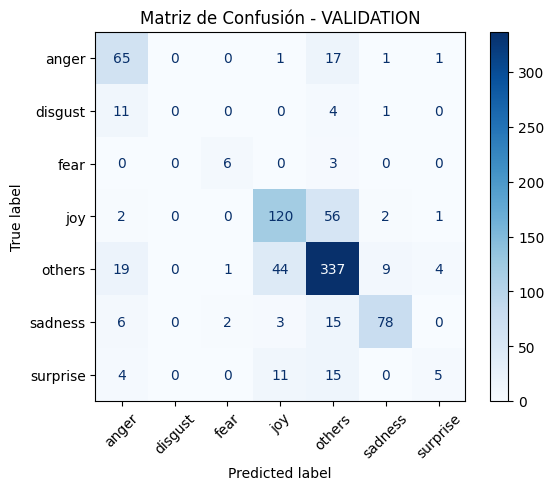

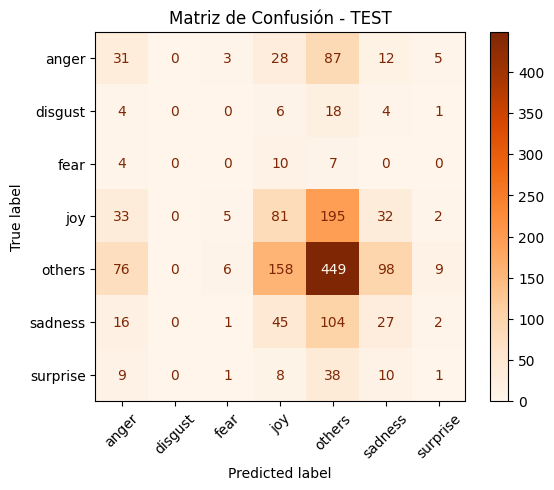

📋 Reporte VALIDATION:
               precision    recall  f1-score   support

       anger       0.61      0.76      0.68        85
     disgust       0.00      0.00      0.00        16
        fear       0.67      0.67      0.67         9
         joy       0.67      0.66      0.67       181
      others       0.75      0.81      0.78       414
     sadness       0.86      0.75      0.80       104
    surprise       0.45      0.14      0.22        35

    accuracy                           0.72       844
   macro avg       0.57      0.54      0.54       844
weighted avg       0.71      0.72      0.71       844

📋 Reporte TEST:
               precision    recall  f1-score   support

       anger       0.18      0.19      0.18       166
     disgust       0.00      0.00      0.00        33
        fear       0.00      0.00      0.00        21
         joy       0.24      0.23      0.24       348
      others       0.50      0.56      0.53       796
     sadness       0.15      0.14     

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/usr/local/lib/python3.12/dist-packag

In [14]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt

# 🔹 Usamos directamente los índices (no el tokenizer)
preds_val = trainer.predict(dataset["validation"])
preds_test = trainer.predict(dataset["test"])

# 🔹 Convertimos logits a clases
pred_labels_val = np.argmax(preds_val.predictions, axis=1)
true_labels_val = preds_val.label_ids

pred_labels_test = np.argmax(preds_test.predictions, axis=1)
true_labels_test = preds_test.label_ids

# 🔹 Matriz de confusión - VALIDATION
cm_val = confusion_matrix(true_labels_val, pred_labels_val)
disp_val = ConfusionMatrixDisplay(confusion_matrix=cm_val, display_labels=label_encoder.classes_)
disp_val.plot(xticks_rotation=45, cmap="Blues")
plt.title("Matriz de Confusión - VALIDATION")
plt.show()

# 🔹 Matriz de confusión - TEST
cm_test = confusion_matrix(true_labels_test, pred_labels_test)
disp_test = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=label_encoder.classes_)
disp_test.plot(xticks_rotation=45, cmap="Oranges")
plt.title("Matriz de Confusión - TEST")
plt.show()

# 🔹 Reportes de métricas
print("📋 Reporte VALIDATION:\n", classification_report(true_labels_val, pred_labels_val, target_names=label_encoder.classes_))
print("📋 Reporte TEST:\n", classification_report(true_labels_test, pred_labels_test, target_names=label_encoder.classes_))


In [15]:
def predecir_emocion(texto):
    # Tokenizar el texto y moverlo al mismo dispositivo del modelo (CPU o GPU)
    inputs = tokenizer(texto, return_tensors="pt", truncation=True, padding=True, max_length=128)
    inputs = {k: v.to(model.device) for k, v in inputs.items()}

    # Obtener logits y predecir
    with torch.no_grad():
        outputs = model(**inputs)
    pred_label_id = outputs.logits.argmax(dim=1).item()
    emocion = id2label[pred_label_id]

    # Mostrar resultados
    print("📝 Texto ingresado:")
    print(f"» {texto}")
    print("🔍 Emoción predicha:")
    print(f"🎯 {emocion.upper()}")
    print("-" * 50)


In [17]:
ejemplos = [
    "Me siento completamente agradecido por todo lo que tengo.",        # Esperado: JOY
    "No puedo dormir, mi ansiedad no me deja en paz.",                 # Esperado: FEAR / SADNESS
    "¡Qué alegría tan grande volver a verte!",                         # Esperado: JOY
    "Estoy furioso con todo lo que pasó hoy en el trabajo.",          # Esperado: ANGER
    "La tristeza me invade, extraño mucho a mi familia.",             # Esperado: SADNESS
    "Esto es tan confuso, no sé qué hacer con mi vida.",              # Esperado: SADNESS
    "¡Qué emoción! ¡Nos vamos de viaje mañana!",                      # Esperado: JOY
    "Tengo miedo de fallar, de que todo salga mal otra vez."          # Esperado: FEAR
]

# Encabezado de resultados
print(f"{'📝 Texto':<70} {'🎯 Esperado':<12} {'🤖 Predicho'}")
print("-" * 100)

for texto in ejemplos:
    inputs = tokenizer(texto, return_tensors="pt", truncation=True, padding=True).to(model.device)
    outputs = model(**inputs)
    pred_label_id = outputs.logits.argmax(dim=1).item()
    emocion_predicha = id2label[pred_label_id]

    # Emoción esperada
    if "agradecido" in texto or "alegría" in texto or "emoción" in texto:
        esperado = "JOY"
    elif "furioso" in texto:
        esperado = "ANGER"
    elif "tristeza" in texto or "confuso" in texto:
        esperado = "SADNESS"
    elif "miedo" in texto or "ansiedad" in texto:
        esperado = "FEAR"
    else:
        esperado = "—"

    print(f"{texto:<70} {esperado:<12} {emocion_predicha.upper()}")


📝 Texto                                                                🎯 Esperado   🤖 Predicho
----------------------------------------------------------------------------------------------------
Me siento completamente agradecido por todo lo que tengo.              JOY          JOY
No puedo dormir, mi ansiedad no me deja en paz.                        FEAR         OTHERS
¡Qué alegría tan grande volver a verte!                                JOY          JOY
Estoy furioso con todo lo que pasó hoy en el trabajo.                  ANGER        SADNESS
La tristeza me invade, extraño mucho a mi familia.                     SADNESS      SADNESS
Esto es tan confuso, no sé qué hacer con mi vida.                      SADNESS      SADNESS
¡Qué emoción! ¡Nos vamos de viaje mañana!                              JOY          JOY
Tengo miedo de fallar, de que todo salga mal otra vez.                 FEAR         FEAR


## Clasificación de emociones usando GPT‑4

### Paso 1: Instalar la librería necesaria

In [28]:
!pip install openai pandas tqdm

### Paso 2: Configuración de la API

In [31]:
# Importamos tqdm para mostrar barras de progreso al procesar múltiples ejemplos
from tqdm import tqdm

# Importamos la clase principal de la API de OpenAI
from openai import OpenAI

# Inicializamos el cliente de OpenAI con tu clave de API personal
# Reemplaza "sk..." con tu clave válida desde https://platform.openai.com/api-keys
client = OpenAI(api_key="sk...")  # ← Sustituir con tu clave personal de OpenAI


###  Paso 3: Librerías

In [32]:
# Importamos pandas para manipulación y análisis de datos tabulares
import pandas as pd

# Importamos random para realizar selecciones aleatorias (por ejemplo, en muestras)
import random

# Importamos time para introducir pausas entre solicitudes (útil al usar APIs)
import time


###  Paso 4: Emociones del dataset EmoEvent

In [41]:
# Lista de emociones del dataset EmoEvent
emociones_posibles = ["anger", "disgust", "fear", "joy", "neutral", "others", "sadness", "surprise"]

# Seleccionamos solo los primeros 100 tweets del test que ya tienes cargado
df_sample = df_test[["tweet", "emotion"]].dropna().head(100).reset_index(drop=True)

### Paso 5: Función para predecir emoción con GPT-4

In [42]:
# Definimos una función para predecir emociones usando el modelo GPT-4o
def gpt4o_predict_manual(texto):
    # Lista de posibles etiquetas de emoción
    etiquetas = ["anger", "sadness", "disgust", "fear", "joy", "surprise", "offensive", "others"]

    try:
        # Hacemos una llamada a la API de OpenAI utilizando el modelo GPT-4o
        response = client.chat.completions.create(
            model="gpt-4o",  # Modelo utilizado
            messages=[
                # Mensaje del sistema indicando las instrucciones para el modelo
                {"role": "system", "content": "Eres un clasificador de emociones. Solo responde con una de estas etiquetas exactas: anger, sadness, disgust, fear, joy, surprise, offensive, others."},
                # Entrada del usuario con el texto a analizar
                {"role": "user", "content": f"¿Qué emoción representa este tweet o frase?: {texto}"}
            ],
            temperature=0  # Temperatura 0 para hacer la respuesta determinista
        )

        # Obtenemos la respuesta del modelo y la convertimos a minúsculas
        output = response.choices[0].message.content.strip().lower()

        # Verificamos si alguna de las etiquetas válidas está en la respuesta
        for etiqueta in etiquetas:
            if etiqueta in output:
                return etiqueta

        # Si no se encontró ninguna etiqueta reconocida, devolvemos "others"
        return "others"

    except Exception as e:
        # En caso de error (por ejemplo, límite de tokens, conexión, etc.)
        print("Error:", e)
        return "error"


In [43]:
# Crear lista para guardar predicciones
preds = []

# Clasificar 100 tweets
for tweet in df_sample["tweet"]:
    pred = gpt4o_predict_manual(tweet)
    preds.append(pred)
    time.sleep(1)

# Agregar columna al DataFrame
df_sample["gpt4o_pred"] = preds

# Mostrar ejemplos
df_sample[["tweet", "emotion", "gpt4o_pred"]].head()

,tweet,emotion,gpt4o_pred
0,"Señor de luz, ven a nosotros en nuestra oscuri...",others,fear
1,Pues ya hemos votado tanto mi madre y yo #Elec...,others,others
2,"#DiaDelLibro 😇⭐❤️🙏🙌😍🌷 sentimientos, viajar con...",joy,joy
3,"¡Feliz #DíaDelLibro📚! ”El libro es fuerza, es ...",joy,joy
4,"Pues qué queréis que os diga, este sarao polít...",joy,joy


In [44]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd


In [45]:
# Importa la función classification_report y la matriz de confusión desde scikit-learn
# Estas se utilizan para evaluar el desempeño del modelo con métricas como precisión, recall y F1
from sklearn.metrics import classification_report, confusion_matrix

# Seaborn se usa para crear gráficos estadísticos más estilizados y fáciles de interpretar
import seaborn as sns

# Matplotlib es la biblioteca estándar para generar gráficos en Python
import matplotlib.pyplot as plt

# Pandas permite manipular datos en forma de tablas (dataframes), útil para análisis y visualización
import pandas as pd


Reporte de Clasificación GPT-4o:

              precision    recall  f1-score   support

       anger      0.700     0.467     0.560        15
     disgust      0.286     0.667     0.400         3
        fear      0.333     1.000     0.500         2
         joy      0.600     0.840     0.700        25
   offensive      0.000     0.000     0.000         0
      others      0.833     0.349     0.492        43
     sadness      0.533     0.889     0.667         9
    surprise      0.600     1.000     0.750         3

    accuracy                          0.580       100
   macro avg      0.486     0.651     0.509       100
weighted avg      0.695     0.580     0.575       100



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


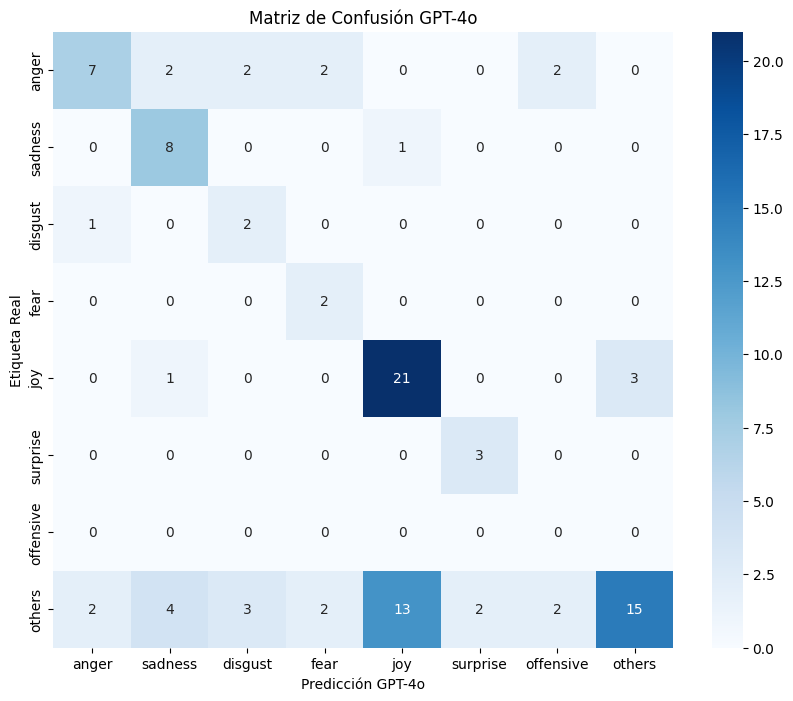

In [46]:
# Obtener matriz de confusión entre las etiquetas reales y las predichas por GPT‑4o
# Se usa la función confusion_matrix especificando el orden de las etiquetas
cm = confusion_matrix(df_sample["emotion"], df_sample["gpt4o_pred"], labels=[
    "anger", "sadness", "disgust", "fear", "joy", "surprise", "offensive", "others"
])

# Visualizar la matriz usando un mapa de calor (heatmap) con Seaborn
plt.figure(figsize=(10, 8))  # Define el tamaño del gráfico
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",  # 'annot' muestra los números, 'fmt' los formatea como enteros
            xticklabels=["anger", "sadness", "disgust", "fear", "joy", "surprise", "offensive", "others"],  # Etiquetas del eje X
            yticklabels=["anger", "sadness", "disgust", "fear", "joy", "surprise", "offensive", "others"])  # Etiquetas del eje Y
plt.xlabel("Predicción GPT-4o")       # Etiqueta del eje X
plt.ylabel("Etiqueta Real")           # Etiqueta del eje Y
plt.title("Matriz de Confusión GPT-4o")  # Título del gráfico
plt.show()  # Muestra el gráfico


In [47]:
ejemplos = [
    ("Me siento completamente agradecido por todo lo que tengo.", "joy"),
    ("No puedo dormir, mi ansiedad no me deja en paz.", "fear"),
    ("¡Qué alegría tan grande volver a verte!", "joy"),
    ("Estoy furioso con todo lo que pasó hoy en el trabajo.", "anger"),
    ("La tristeza me invade, extraño mucho a mi familia.", "sadness"),
    ("Esto es tan confuso, no sé qué hacer con mi vida.", "sadness"),
    ("¡Qué emoción! ¡Nos vamos de viaje mañana!", "joy"),
    ("Tengo miedo de fallar, de que todo salga mal otra vez.", "fear")
]

# Imprimir encabezado
print(f"{'📝 Texto':<70} {'🎯 Esperado':<12} {'🤖 GPT-4o Predicho'}")
print("-" * 100)

# Aplicar predicción
for texto, esperado in ejemplos:
    predicho = gpt4o_predict_manual(texto)
    print(f"{texto:<70} {esperado.upper():<12} {predicho.upper()}")

📝 Texto                                                                🎯 Esperado   🤖 GPT-4o Predicho
----------------------------------------------------------------------------------------------------
Me siento completamente agradecido por todo lo que tengo.              JOY          JOY
No puedo dormir, mi ansiedad no me deja en paz.                        FEAR         FEAR
¡Qué alegría tan grande volver a verte!                                JOY          JOY
Estoy furioso con todo lo que pasó hoy en el trabajo.                  ANGER        ANGER
La tristeza me invade, extraño mucho a mi familia.                     SADNESS      SADNESS
Esto es tan confuso, no sé qué hacer con mi vida.                      SADNESS      SADNESS
¡Qué emoción! ¡Nos vamos de viaje mañana!                              JOY          JOY
Tengo miedo de fallar, de que todo salga mal otra vez.                 FEAR         FEAR


## Paso a paso para fine-tuning de T5

### Paso 1: Instalar dependencias

In [ ]:
# Instalación de las dependencias necesarias para trabajar con modelos de HuggingFace y evaluación
!pip install -U "transformers>=4.35.0" --quiet      # Biblioteca para cargar y ajustar modelos como T5
!pip install -U "datasets>=2.14.0" "evaluate>=0.4.0" scikit-learn --quiet
# datasets: para manipular datasets compatibles con HuggingFace
# evaluate: para calcular métricas como accuracy o F1
# scikit-learn: incluye herramientas para evaluación como clasificación, matriz de confusión, etc.


### Paso 2: Importar librerías

In [48]:
# Importación de librerías necesarias

import evaluate                        # Librería de HuggingFace para calcular métricas de evaluación como accuracy, F1, etc.
import pandas as pd                   # Manipulación y análisis de estructuras de datos (DataFrames)
import numpy as np                    # Operaciones numéricas eficientes con arreglos
from sklearn.preprocessing import LabelEncoder  # Codificación de etiquetas categóricas a valores numéricos

from datasets import Dataset, DatasetDict  # Manejo de datasets en formato compatible con HuggingFace

from transformers import (
    AutoTokenizer,                    # Carga automática del tokenizador asociado al modelo
    AutoModelForSeq2SeqLM,           # Modelo preentrenado para tareas de secuencia a secuencia (como T5)
    Seq2SeqTrainingArguments,        # Argumentos específicos para entrenamiento de modelos Seq2Seq
    Seq2SeqTrainer                   # Clase que facilita el entrenamiento de modelos de traducción, resumen, etc.
)

import torch                          # Librería principal para computación con tensores (utilizada por Transformers)

# Desactiva el tracking de experimentos con Weights & Biases (por defecto viene activado en HuggingFace Trainer)
import os
os.environ["WANDB_DISABLED"] = "true"


### Paso 3: Cargar datos desde GitHub

In [49]:
# URLs de los archivos .tsv del dataset EmoEvent (dividido en entrenamiento, validación y prueba)
url_train = "https://raw.githubusercontent.com/fmplaza/EmoEvent/master/splits/es/train.tsv"
url_dev   = "https://raw.githubusercontent.com/fmplaza/EmoEvent/master/splits/es/dev.tsv"
url_test  = "https://raw.githubusercontent.com/fmplaza/EmoEvent/master/splits/es/test.tsv"

# Cargar los archivos .tsv directamente desde GitHub usando pandas
df_train = pd.read_csv(url_train, sep="\t")   # Dataset de entrenamiento
df_dev   = pd.read_csv(url_dev, sep="\t")     # Dataset de validación
df_test  = pd.read_csv(url_test, sep="\t")    # Dataset de prueba

# Limpiar los nombres de columnas (algunos vienen con espacios ocultos o caracteres invisibles)
for df in [df_train, df_dev, df_test]:
    df.columns = df.columns.str.strip()


### Paso 4: Eliminar nulos y seleccionar columnas

In [50]:
# Eliminar filas que tengan valores nulos en la columna 'tweet' (no queremos textos vacíos)
df_train.dropna(subset=["tweet"], inplace=True)
df_dev.dropna(subset=["tweet"], inplace=True)
df_test.dropna(subset=["tweet"], inplace=True)

# Seleccionar solo las columnas necesarias: 'tweet' (texto) y 'emotion' (etiqueta)
# Luego se renombran: 'tweet' → 'text' y 'emotion' → 'label', para adaptarse al formato de entrenamiento con T5
df_train = df_train[["tweet", "emotion"]].rename(columns={"tweet": "text", "emotion": "label"})
df_dev   = df_dev[["tweet", "emotion"]].rename(columns={"tweet": "text", "emotion": "label"})
df_test  = df_test[["tweet", "emotion"]].rename(columns={"tweet": "text", "emotion": "label"})

# Crear un DatasetDict de Hugging Face con las tres divisiones del dataset
dataset = DatasetDict({
    "train": Dataset.from_pandas(df_train),
    "validation": Dataset.from_pandas(df_dev),
    "test": Dataset.from_pandas(df_test)
})

# Obtener la lista ordenada de clases únicas (etiquetas de emociones)
label_list = sorted(df_train["label"].unique())
print("Etiquetas:", label_list)


Etiquetas: ['anger', 'disgust', 'fear', 'joy', 'others', 'sadness', 'surprise']


### Paso 5: Tokenizar usando T5

In [64]:
# Definir el nombre del modelo T5 preentrenado a utilizar (en este caso, FLAN-T5 en su versión pequeña)
model_name = "google/flan-t5-small"

# Cargar el tokenizer correspondiente al modelo seleccionado
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Función de preprocesamiento para un solo ejemplo (no utilizada en el mapeo por lotes)
# Convierte texto y etiqueta en secuencias tokenizadas, aunque no se usa directamente aquí
def preprocess(example):
    return tokenizer(
        f"Clasifica la emoción: {example['text']}",
        padding="max_length",
        truncation=True,
        max_length=128
    ) | tokenizer(
        example["label"],
        padding="max_length",
        truncation=True,
        max_length=10
    )

# Función para tokenizar múltiples ejemplos al mismo tiempo (mejor rendimiento)
def preprocess_all(batch):
    # Crear los inputs concatenando la instrucción + texto para cada entrada
    inputs = tokenizer([f"Clasifica la emoción: {t}" for t in batch["text"]],
                       max_length=128,
                       truncation=True,
                       padding="max_length")

    # Tokenizar las etiquetas como texto objetivo (se generan como secuencia)
    targets = tokenizer(batch["label"],
                        max_length=10,
                        truncation=True,
                        padding="max_length")

    # Retornar inputs, masks y labels (labels serán los input_ids de las etiquetas)
    return {
        "input_ids": inputs["input_ids"],
        "attention_mask": inputs["attention_mask"],
        "labels": targets["input_ids"]
    }

# Aplicar la tokenización a todo el dataset (entrenamiento, validación y test)
# Se eliminan las columnas originales 'text' y 'label' luego de tokenizar
tokenized_dataset = dataset.map(preprocess_all, batched=True, remove_columns=["text", "label"])


Map:   0%|          | 0/5723 [00:00<?, ? examples/s]

Map:   0%|          | 0/844 [00:00<?, ? examples/s]

Map:   0%|          | 0/1626 [00:00<?, ? examples/s]

### Paso 6: Cargar modelo T5

In [65]:
# Cargar el modelo T5 preentrenado (en este caso: google/flan-t5-small)
# Este modelo es del tipo encoder-decoder (Seq2Seq) y está preparado para tareas de generación de texto.
# En este caso, lo utilizaremos para generar etiquetas emocionales como texto.
model = AutoModelForSeq2SeqLM.from_pretrained(model_name)


### Paso 7: Configurar entrenamiento

In [66]:
# Definimos los argumentos para el entrenamiento del modelo T5 usando el Trainer de Hugging Face
training_args = Seq2SeqTrainingArguments(
    output_dir="./results_t5",               # Carpeta donde se guardarán los checkpoints y resultados
    eval_strategy="epoch",                   # Evaluación al final de cada época
    save_strategy="epoch",                   # Guardar el modelo al final de cada época
    learning_rate=2e-4,                      # Tasa de aprendizaje (puede ajustarse según el modelo/dataset)
    per_device_train_batch_size=16,          # Tamaño del batch para entrenamiento por dispositivo
    per_device_eval_batch_size=16,           # Tamaño del batch para evaluación por dispositivo
    num_train_epochs=4,                      # Número total de épocas de entrenamiento
    predict_with_generate=True,              # Activar generación de texto al hacer predicciones (importante en Seq2Seq)
    logging_dir="./logs",                    # Carpeta donde se almacenan los logs de entrenamiento
    report_to="none"                         # Desactivar reportes a herramientas como WandB o TensorBoard
)


### Paso 8: Definir métrica personalizada

In [71]:
# Cargamos la métrica de evaluación "accuracy" desde la librería evaluate
metric = evaluate.load("accuracy")

# Función para calcular métricas de evaluación personalizada
def compute_metrics(eval_pred):
    predictions, labels = eval_pred  # Se separan las predicciones y etiquetas verdaderas

    # Decodificamos las secuencias generadas y las etiquetas (que vienen como IDs) a texto
    decoded_preds = tokenizer.batch_decode(predictions, skip_special_tokens=True)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    # Normalizamos eliminando espacios extras y convirtiendo a minúsculas
    decoded_preds = [p.strip().lower() for p in decoded_preds]
    decoded_labels = [l.strip().lower() for l in decoded_labels]

    # Calculamos la precisión (accuracy) manualmente comparando texto exacto
    correct_predictions = sum([1 for pred, label in zip(decoded_preds, decoded_labels) if pred == label])
    accuracy = correct_predictions / len(decoded_labels) if len(decoded_labels) > 0 else 0

    # Retornamos el valor en un diccionario para que Trainer lo pueda utilizar
    return {"accuracy": accuracy}


### Paso 9: Entrenar

In [72]:
# Creamos una instancia del entrenador (Trainer) especializada para modelos de tipo Seq2Seq (como T5)
trainer = Seq2SeqTrainer(
    model=model,                           # El modelo previamente cargado (Flan-T5 en este caso)
    args=training_args,                    # Argumentos de entrenamiento definidos anteriormente
    train_dataset=tokenized_dataset["train"],       # Conjunto de entrenamiento tokenizado
    eval_dataset=tokenized_dataset["validation"],   # Conjunto de validación tokenizado
    tokenizer=tokenizer,                  # Tokenizador usado para el modelo
    compute_metrics=compute_metrics       # Función personalizada para calcular métricas (accuracy)
)

# Iniciamos el entrenamiento del modelo con los datos proporcionados
trainer.train()


/tmp/ipython-input-1414467820.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.210572,0.542654
2,0.049900,0.103224,0.657583
3,0.089600,0.104788,0.631517
4,0.089600,0.107344,0.631517


TrainOutput(global_step=1432, training_loss=0.07277219655127498, metrics={'train_runtime': 341.293, 'train_samples_per_second': 67.074, 'train_steps_per_second': 4.196, 'total_flos': 1063851358420992.0, 'train_loss': 0.07277219655127498, 'epoch': 4.0})

### Paso 10: Evaluar en test

In [73]:
# Evaluamos el modelo entrenado utilizando el conjunto de prueba (test)
# Esta evaluación utilizará la función `compute_metrics` definida previamente para calcular la exactitud.
trainer.evaluate(tokenized_dataset["test"])


{'eval_loss': 0.29731059074401855,
 'eval_accuracy': 0.3462484624846248,
 'eval_runtime': 11.0165,
 'eval_samples_per_second': 147.597,
 'eval_steps_per_second': 9.259,
 'epoch': 4.0}

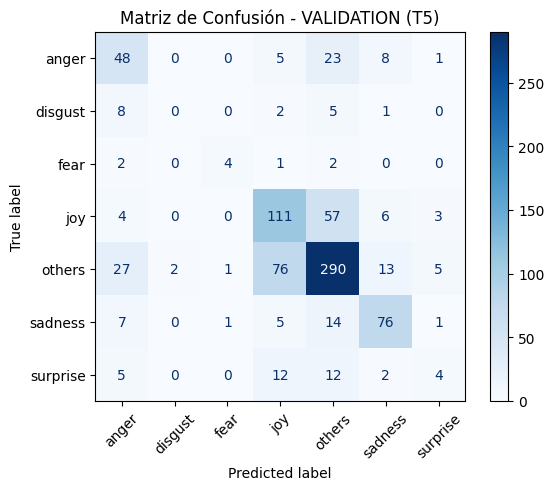

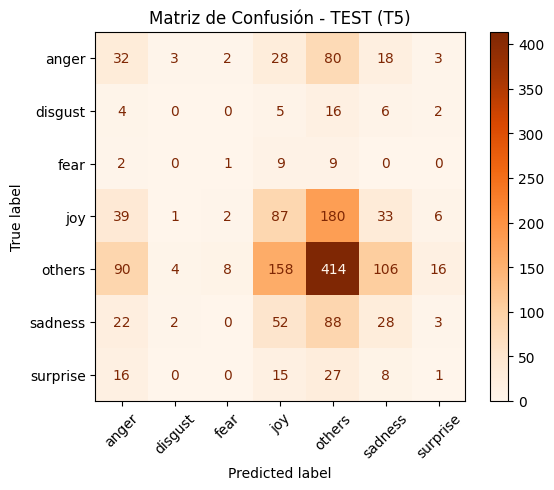

📋 Reporte VALIDATION (T5):
               precision    recall  f1-score   support

       anger       0.48      0.56      0.52        85
     disgust       0.00      0.00      0.00        16
        fear       0.67      0.44      0.53         9
         joy       0.52      0.61      0.56       181
      others       0.72      0.70      0.71       414
     sadness       0.72      0.73      0.72       104
    surprise       0.29      0.11      0.16        35

    accuracy                           0.63       844
   macro avg       0.48      0.45      0.46       844
weighted avg       0.62      0.63      0.62       844

📋 Reporte TEST (T5):
               precision    recall  f1-score   support

       anger       0.16      0.19      0.17       166
     disgust       0.00      0.00      0.00        33
        fear       0.08      0.05      0.06        21
         joy       0.25      0.25      0.25       348
      others       0.51      0.52      0.51       796
     sadness       0.14     

In [75]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt

# Usamos directamente los índices (no el tokenizer)
preds_val = trainer.predict(tokenized_dataset["validation"])
preds_test = trainer.predict(tokenized_dataset["test"])

# Convertimos logits a clases
# For T5, predictions are generated token IDs, not logits
pred_token_ids_val = preds_val.predictions
true_token_ids_val = preds_val.label_ids

pred_token_ids_test = preds_test.predictions
true_token_ids_test = preds_test.label_ids

# Decode token IDs back to strings
pred_labels_val = tokenizer.batch_decode(pred_token_ids_val, skip_special_tokens=True)
true_labels_val = tokenizer.batch_decode(true_token_ids_val, skip_special_tokens=True)

pred_labels_test = tokenizer.batch_decode(pred_token_ids_test, skip_special_tokens=True)
true_labels_test = tokenizer.batch_decode(true_token_ids_test, skip_special_tokens=True)


# Normalize labels (as done in compute_metrics)
pred_labels_val = [p.strip().lower() for p in pred_labels_val]
true_labels_val = [l.strip().lower() for l in true_labels_val]
pred_labels_test = [p.strip().lower() for p in pred_labels_test]
true_labels_test = [l.strip().lower() for l in true_labels_test]


# Matriz de confusión - VALIDATION
# We need the unique labels from both true and predicted to ensure the matrix is square and includes all possible labels
all_labels = sorted(list(set(true_labels_val + pred_labels_val)))
cm_val = confusion_matrix(true_labels_val, pred_labels_val, labels=all_labels)
disp_val = ConfusionMatrixDisplay(confusion_matrix=cm_val, display_labels=all_labels)
disp_val.plot(xticks_rotation=45, cmap="Blues")
plt.title("Matriz de Confusión - VALIDATION (T5)")
plt.show()

# Matriz de confusión - TEST
all_labels = sorted(list(set(true_labels_test + pred_labels_test)))
cm_test = confusion_matrix(true_labels_test, pred_labels_test, labels=all_labels)
disp_test = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=all_labels)
disp_test.plot(xticks_rotation=45, cmap="Oranges")
plt.title("Matriz de Confusión - TEST (T5)")
plt.show()

# Reportes de métricas
# We need the unique labels from both true and predicted for the classification report as well
target_names_val = sorted(list(set(true_labels_val + pred_labels_val)))
print("📋 Reporte VALIDATION (T5):\n", classification_report(true_labels_val, pred_labels_val, target_names=target_names_val, zero_division=0))

target_names_test = sorted(list(set(true_labels_test + pred_labels_test)))
print("📋 Reporte TEST (T5):\n", classification_report(true_labels_test, pred_labels_test, target_names=target_names_test, zero_division=0))

In [78]:
# Función para predecir con T5
def predecir_emocion_t5(texto):
    entrada = f"Clasifica la emoción: {texto}"
    inputs = tokenizer(entrada, return_tensors="pt", truncation=True, padding=True, max_length=128).to(model.device)
    outputs = model.generate(**inputs, max_new_tokens=3)
    pred = tokenizer.decode(outputs[0], skip_special_tokens=True)
    return pred.strip().upper()

# Lista de ejemplos con emociones esperadas
ejemplos = [
    "Me siento completamente agradecido por todo lo que tengo.",        # Esperado: JOY
    "No puedo dormir, mi ansiedad no me deja en paz.",                 # Esperado: FEAR / SADNESS
    "¡Qué alegría tan grande volver a verte!",                         # Esperado: JOY
    "Estoy furioso con todo lo que pasó hoy en el trabajo.",          # Esperado: ANGER
    "La tristeza me invade, extraño mucho a mi familia.",             # Esperado: SADNESS
    "Esto es tan confuso, no sé qué hacer con mi vida.",              # Esperado: SADNESS
    "¡Qué emoción! ¡Nos vamos de viaje mañana!",                      # Esperado: JOY
    "Tengo miedo de fallar, de que todo salga mal otra vez."          # Esperado: FEAR
]

# Encabezado de la tabla
print(f"{'📝 Texto':<70} {'🎯 Esperado':<12} {'🤖 Predicho'}")
print("-" * 100)

# Iterar sobre los ejemplos
for texto in ejemplos:
    # Estimar emoción esperada manualmente
    if "agradecido" in texto or "alegría" in texto or "emoción" in texto:
        esperado = "JOY"
    elif "furioso" in texto:
        esperado = "ANGER"
    elif "tristeza" in texto or "confuso" in texto:
        esperado = "SADNESS"
    elif "miedo" in texto or "ansiedad" in texto:
        esperado = "FEAR"
    else:
        esperado = "—"

    # Predecir emoción usando tu modelo T5
    predicho = predecir_emocion_t5(texto)

    # Mostrar resultados en tabla
    print(f"{texto:<70} {esperado:<12} {predicho}")


📝 Texto                                                                🎯 Esperado   🤖 Predicho
----------------------------------------------------------------------------------------------------
Me siento completamente agradecido por todo lo que tengo.              JOY          JOY
No puedo dormir, mi ansiedad no me deja en paz.                        FEAR         SADNESS
¡Qué alegría tan grande volver a verte!                                JOY          JOY
Estoy furioso con todo lo que pasó hoy en el trabajo.                  ANGER        JOY
La tristeza me invade, extraño mucho a mi familia.                     SADNESS      SADNESS
Esto es tan confuso, no sé qué hacer con mi vida.                      SADNESS      ANGER
¡Qué emoción! ¡Nos vamos de viaje mañana!                              JOY          JOY
Tengo miedo de fallar, de que todo salga mal otra vez.                 FEAR         FEAR
